In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'w'

In [2]:
%load_ext autoreload
%autoreload 2
from experiment import Runner

In [3]:
exp_click = Runner(dataset='click', params={})

[3657] [exp] click | window_size = 5000, n_epoch = 1
[3657] [exp] n_sample = 3570; 714 (20%) + 357 (10%) + 2499 (70%)
[3657] [exp] n_user = 3570, n_item = 5


In [4]:
exp_ML100k = Runner(dataset='ML100k', params={})

[3657] [exp] ML100k | window_size = 5000, n_epoch = 1
[3657] [exp] n_sample = 21201; 4240 (20%) + 2120 (10%) + 14841 (70%)
[3657] [exp] n_user = 928, n_item = 1172


### prepare

In [5]:
# http://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

In [80]:
def read_result(dirname, dataset, method, T, n_trial):
    t_reco = t_update = 0.
    results = []
    
    if type(n_trial) == str:  # read a specific trial
        path = dirname + '/' + '_'.join([dataset, method, T, n_trial]) + '.txt'
        with open(path) as f:
            lines = list(map(lambda l: float(l.rstrip()), f.readlines()))
            recalls = lines[2:]
        return recalls 
    
    for trial in range(1, n_trial + 1):
        path = dirname + '/' + '_'.join([dataset, method, T, str(trial)]) + '.txt'
        with open(path) as f:
            lines = list(map(lambda l: float(l.rstrip()), f.readlines()))
            t_reco += lines[0]
            t_update += lines[1]
            results.append(lines[2:])
            
    return {'t_reco': t_reco / n_trial, 't_update': t_update / n_trial, 'results': results}

In [88]:
def show_results(MF, iMF, FMs, iFMs, sketch):
    print('static MF')
    print('=========')
    print('avg. reco time      = %.5f' % MF['t_reco'])
    print('avg. update time    = ---') 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(MF['results']), np.std(MF['results'])))
    print()
    
    print('iMF')
    print('===')
    print('avg. reco time      = %.5f' % iMF['t_reco'])
    print('avg. update time    = %.5f' % iMF['t_update']) 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(iMF['results']), np.std(iMF['results'])))
    print()
    
    print('static FMs')
    print('==========')
    print('avg. reco time      = %.5f' % FMs['t_reco'])
    print('avg. update time    = ---') 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(FMs['results']), np.std(FMs['results'])))
    print()
    
    print('iFMs')
    print('====')
    print('avg. reco time      = %.5f' % iFMs['t_reco'])
    print('avg. update time    = %.5f' % iFMs['t_update']) 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(iFMs['results']), np.std(iFMs['results'])))
    print()
    
    print('sketch')
    print('======')
    print('avg. reco time      = %.5f' % sketch['t_reco'])
    print('avg. update time    = %.5f' % sketch['t_update']) 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(sketch['results']), np.std(sketch['results'])))
    print()

In [89]:
def plot(name, exp, MF, iMF, FMs, iFMs, sketch, N=10, T=5000, ylabel='recall@N'):

    # plot incremental recall
    offset = exp.data.n_batch_train + exp.data.n_batch_test
    x = np.arange(exp.data.n_sample - offset) + offset

    every = int(exp.data.n_test / 8)

    best = np.argsort([sum(l) for l in MF['results']])[-1]
    plt.plot(x, MF['results'][best], c=colors[4], label='static MF', ms=8., mfc='none', marker='s', mew=1.2, mec=colors[4], markevery=(int(every/2), every))

    best = np.argsort([sum(l) for l in iMF['results']])[-1]
    plt.plot(x, iMF['results'][best], c=colors[0], label='iMF', ms=8., marker='s', mew=0, markevery=every)
    
    best = np.argsort([sum(l) for l in FMs['results']])[-1]
    plt.plot(x, FMs['results'][best], c=colors[2], label='static FMs', ms=10., mfc='none', marker='^', mew=1.2, mec=colors[2], markevery=(int(every/2), every))
    
    best = np.argsort([sum(l) for l in iFMs['results']])[-1]
    plt.plot(x, iFMs['results'][best], c=colors[6], label='iFMs', marker='^', ms=10., mew=0, markevery=every)
    
    best = np.argsort([sum(l) for l in sketch['results']])[-1]
    plt.plot(x, sketch['results'][best], c=colors[8], label='sketch', marker='o', ms=6., mew=0, markevery=every)
    
    plt.xlabel(r'old $\leftarrow$ sample index $\rightarrow$ new', fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    
    ax = plt.gca()
    ax.yaxis.grid(True)
    ax.patch.set_visible(False)
    
    plt.yticks([0.00, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15])
    plt.ylim([0.0, 0.15])
     
    # head-of-evaluate | first T samples (1st window)
    ax.axvline(x=(offset - 1 + T - 1), linewidth=1, linestyle=':', color=colors[14])
    
    fig = plt.gcf()
    fig.set_size_inches((5.5, 3))
    fig.patch.set_alpha(0.0)
    
    plt.title('%s (T = %d)' % (name, T), fontweight='bold')
    plt.xlim((0, exp.data.n_sample - 1))
    
    plt.tight_layout()

## Synthetic click

### Recall

In [86]:
3## k=2, reg_w0=2., reg_w=8., reg_V=16., lr=0.001, epoch=1
click_staticFMs = read_result('results/recprofile/click', 'click', 'static-FMs', '500', 5)
click_iFMs = read_result('results/recprofile/click', 'click', 'iFMs', '500', 5)

## k=2, reg=0.01, lr=0.001, epoch=100
click_staticMF = read_result('results/recprofile/click', 'click', 'static-MF', '500', 5)
click_iMF = read_result('results/recprofile/click', 'click', 'iMF', '500', 5)

click_sketch = read_result('results', 'click', 'sketch', '500', 1)

static MF
avg. reco time      = 0.00003
avg. update time    = ---
recall: mean (±std) = 0.195 (±0.105)

iMF
===
avg. reco time      = 0.00002
avg. update time    = 0.00002
recall: mean (±std) = 0.207 (±0.098)

static FMs
avg. reco time      = 0.00284
avg. update time    = ---
recall: mean (±std) = 0.257 (±0.122)

iFMs
====
avg. reco time      = 0.00290
avg. update time    = 0.00024
recall: mean (±std) = 0.276 (±0.148)

sketch
avg. reco time      = 0.00205
avg. update time    = 0.00033
recall: mean (±std) = 0.234 (±0.196)



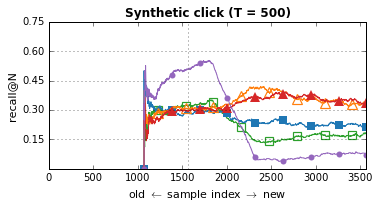

In [90]:
plot('Synthetic click', exp_click, click_staticMF, click_iMF, click_staticFMs, click_iFMs, click_sketch, N=1, T=500)
plt.yticks([.15, .30, .45, .60, .75])
plt.ylim([0.0, .75])

show_results(click_staticMF, click_iMF, click_staticFMs, click_iFMs, click_sketch)

### MPR

In [91]:
# click_staticFMs_MPR = read_result('results', 'click', 'static-FMs_MPR', '500', 5)
click_iFMs_MPR = read_result('results', 'click', 'iFMs_MPR', '500', 5)

# click_staticMF_MPR = read_result('results', 'click', 'static-MF_MPR', '500', 5)
click_iMF_MPR = read_result('results', 'click', 'iMF_MPR', '500', 5)

click_sketch_MPR = read_result('results', 'click', 'sketch_MPR', '500', 1)

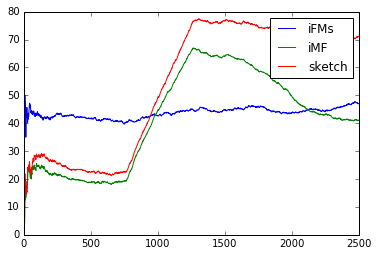

In [102]:
plt.plot(click_iFMs_MPR['results'][4], label='iFMs')
plt.plot(click_iMF_MPR['results'][3], label='iMF')
plt.plot(click_sketch_MPR['results'][0], label='sketch')
plt.legend()

## ML100k

### Recall

In [69]:
## k=40, reg_w0=2., reg_w=8., reg_V=16., lr=0.004, epoch=3
ML100k_staticFMs = read_result('results/recprofile/ML100k', 'ML100k', 'static-FMs', '3000', 5)
ML100k_iFMs = read_result('results/recprofile/ML100k', 'ML100k', 'iFMs', '3000', 5)

## k=40, reg=0.01, lr=0.003, epoch=20
ML100k_staticMF = read_result('results/recprofile/ML100k', 'ML100k', 'static-MF', '3000', 5)
ML100k_iMF = read_result('results/recprofile/ML100k', 'ML100k', 'iMF', '3000', 5)

ML100k_sketch = read_result('results', 'ML100k', 'sketch', '3000', 1)

static MF
avg. reco time      = 0.00015
avg. update time    = ---
recall: mean (±std) = 0.020 (±0.004)

iMF
===
avg. reco time      = 0.00017
avg. update time    = 0.00003
recall: mean (±std) = 0.029 (±0.009)

static FMs
avg. reco time      = 0.02530
avg. update time    = ---
recall: mean (±std) = 0.021 (±0.008)

iFMs
====
avg. reco time      = 0.02687
avg. update time    = 0.00164
recall: mean (±std) = 0.034 (±0.008)

sketch
avg. reco time      = 0.01699
avg. update time    = 0.00046
recall: mean (±std) = 0.025 (±0.005)



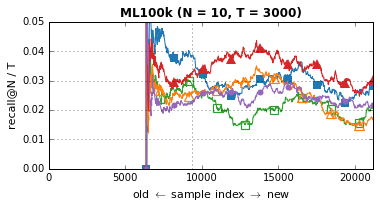

In [75]:
plot('ML100k', exp_ML100k, ML100k_staticMF, ML100k_iMF, ML100k_staticFMs, ML100k_iFMs, ML100k_sketch, N=10, T=3000)
plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
plt.ylim([0.0, 0.05])

show_results(ML100k_staticMF, ML100k_iMF, ML100k_staticFMs, ML100k_iFMs, ML100k_sketch)

### MPR

In [107]:
# ML100k_staticFMs_MPR = read_result('results', 'ML100k', 'static-FMs_MPR', '3000', 5)
ML100k_iFMs_MPR = read_result('results', 'ML100k', 'iFMs_MPR', '3000', 1)

# ML100k_staticMF_MPR = read_result('results', 'ML100k', 'static-MF_MPR', '3000', 5)
ML100k_iMF_MPR = read_result('results', 'ML100k', 'iMF_MPR', '3000', 5)

ML100k_sketch_MPR = read_result('results', 'ML100k', 'sketch_MPR', '3000', 1)
ML100k_popular_MPR = read_result('results', 'ML100k', 'popular_MPR', '3000', 1)

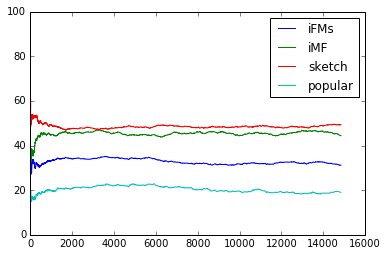

In [108]:
plt.plot(ML100k_iFMs_MPR['results'][0], label='iFMs')
plt.plot(ML100k_iMF_MPR['results'][0], label='iMF')
plt.plot(ML100k_sketch_MPR['results'][0], label='sketch')
plt.plot(ML100k_popular_MPR['results'][0], label='popular')
plt.legend()